In [ ]:
!unzip UTKFaceFull.zip

In [27]:
import os
import glob

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from PIL import Image

dataset_folder_name = 'dataset/UTKFace'
outputfile_name = "df_predictions_all_test.csv"


TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

TRAIN_WITH_WEIGTHS = True

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [37]:
#weights = {'female': {'white': {'weight': 1.0000859768999493, 'total': 1388}, 'black': {'weight': 1.0000947320909475, 'total': 655}, 'asian': {'weight': 0.9996453453531876, 'total': 568}, 'indian': {'weight': 1.000131283142888, 'total': 523}, 'others': {'weight': 1.0001248417406206, 'total': 298}}, 'male': {'white': {'weight': 1.00007922120209, 'total': 1616}, 'black': {'weight': 0.9998653674745138, 'total': 681}, 'asian': {'weight': 0.999727850814823, 'total': 459}, 'indian': {'weight': 0.9999673852528987, 'total': 637}, 'others': {'weight': 1.0001095340344832, 'total': 215}}}
weights = {'female': 1.1, 'male': 0.90}
                  #sample_weights.append(weights[dataset_dict['gender_id'][gender]][dataset_dict['race_id'][race]]['weight'])

def get_weight(gender, age, race):
    return weights[dataset_dict['gender_id'][gender]]


get_weight(0,0,0)

0.9

In [29]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df


df = parse_dataset(dataset_folder_name)
print(df.head())

     age  gender   race                                               file
0  100.0    male  white  dataset/UTKFace\100_0_0_20170112213500903.jpg....
1  100.0    male  white  dataset/UTKFace\100_0_0_20170112215240346.jpg....
2  100.0  female  white  dataset/UTKFace\100_1_0_20170110183726390.jpg....
3  100.0  female  white  dataset/UTKFace\100_1_0_20170112213001988.jpg....
4  100.0  female  white  dataset/UTKFace\100_1_0_20170112213303693.jpg....


In [30]:
class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.RandomState(seed=42).permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])

        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16, include_weights=False, include_files=False):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []

        # weights
        sample_weights = []
        files = []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']
                
                


                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                if include_weights:
                  sample_weights.append(get_weight(gender, age, race))

                if include_files:
                  files.append(file)

                # yielding condition
                if len(images) >= batch_size:
                    if include_files and include_weights:
                      yield np.array(images), [np.array(ages), np.array(races), np.array(genders)], np.array(sample_weights), np.array(files)
                    
                    elif include_files:
                      yield np.array(images), [np.array(ages), np.array(races), np.array(genders)], np.array(files)

                    elif include_weights:
                      yield np.array(images), [np.array(ages), np.array(races), np.array(genders)], np.array(sample_weights)

                    else:
                      yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]

                    images, ages, races, genders, sample_weights, files = [], [], [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [5]:
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)

        return x

    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")

        return model

    def assemble_gender_only(self, width, height):
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = gender_branch,
                     name="face_net")

        return model

    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))

model.summary()


Model: "face_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 198, 198, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 198, 198, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 198, 198, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 198, 198, 16) 448         input_1[0][0]                    
___________________________________________________________________________________________

In [6]:
from tensorflow.keras.optimizers import Adam


init_lr = 1e-4
epochs = 2

opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

In [7]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size, include_weights=TRAIN_WITH_WEIGTHS)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size, include_weights=TRAIN_WITH_WEIGTHS)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/2
362/362 [==============================] - 1500s 4s/step - loss: 15.4713 - age_output_loss: 3.0825 - race_output_loss: 2.0445 - gender_output_loss: 0.7458 - age_output_mae: 1.3666 - race_output_accuracy: 0.3465 - gender_output_accuracy: 0.6753 - val_loss: 7.5740 - val_age_output_loss: 1.1825 - val_race_output_loss: 1.8411 - val_gender_output_loss: 0.8244 - val_age_output_mae: 0.8657 - val_race_output_accuracy: 0.4675 - val_gender_output_accuracy: 0.5758
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/2
362/362 [==============================] - 1308s 4s/step - loss: 8.5374 - age_output_loss: 1.5924 - race_output_loss: 1.4111 - gender_output_loss: 0.5126 - age_output_mae: 0.9752 - race_output_accuracy: 0.5247 - gender_output_accuracy: 0.7892 - val_loss: 29.2911 - val_age_output_loss: 6.7994 - val_race_output_loss: 1.3680 - val_gender_output_loss: 0.4133 - val_age_output_mae: 1.8213 - val_race_output_accuracy: 0.5442 - val_gender_output_accuracy: 0.8310
INF

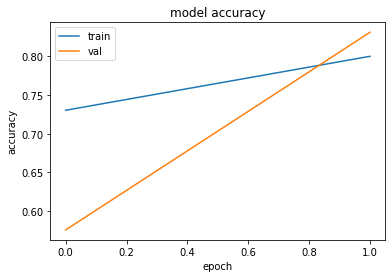

In [31]:
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
test_batch_size = 128
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, race_pred, gender_pred = model.predict_generator(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

C:\Users\thoma\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [33]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size, include_weights=True, include_files=True)
samples = 0
images, age_true, race_true, gender_true, sample_weights, files = [], [], [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)

    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])

    sample_weights.extend(test_batch[2])
    files.extend(test_batch[3])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

age_pred_flat = age_pred.flatten()

In [34]:
from sklearn.metrics import classification_report

cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

              precision    recall  f1-score   support

        male       0.85      0.80      0.82      3691
      female       0.79      0.85      0.82      3349

    accuracy                           0.82      7040
   macro avg       0.82      0.82      0.82      7040
weighted avg       0.82      0.82      0.82      7040



In [35]:
df_prediction = pd.DataFrame({'age_true': age_true, 'age_pred': age_pred_flat, 'race_true': race_true, 'race_pred': race_pred, 'gender_true': gender_true, 'gender_pred': gender_pred})
df_prediction = df_prediction.round(0).astype(int)
df_prediction['weights'] = sample_weights
df_prediction['files'] = files
df_prediction.head()

,age_true,age_pred,race_true,race_pred,gender_true,gender_pred,weights,files
0,29,446,4,0,0,0,0.9,dataset/UTKFace\29_0_4_20170103235840396.jpg.c...
1,60,62,1,1,1,0,1.1,dataset/UTKFace\60_1_1_20170113185112295.jpg.c...
2,5,158,4,1,1,0,1.1,dataset/UTKFace\5_1_4_20170116232419298.jpg.ch...
3,26,-23,3,3,1,1,1.1,dataset/UTKFace\26_1_3_20170119180953860.jpg.c...
4,16,105,0,0,0,0,0.9,dataset/UTKFace\16_0_0_20170110232450588.jpg.c...


In [36]:
import time

outfilebase = time.strftime("%Y%m%d-%H%M%S", time.gmtime(time.time()))

outputfile = outfilebase + '_' + outputfile_name

df_prediction.to_csv(outputfile)